In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc,precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import KFold
import itertools
import xgboost as xgb

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='crest'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [59]:
class_names = ['Not Retained','Retained'] 

In [2]:
data = pd.read_json('ultimate_data_challenge.json')

In [3]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
data.shape

(50000, 12)

50,000 rows and 12 fearues. 

In [5]:
data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
data['avg_rating_of_driver'] = data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].mean())
data['avg_rating_by_driver'] = data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].mean())

In [8]:
data['phone'] = data['phone'].fillna(data['phone'].mode()[0])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


First thing I did was take care of missing values. I imputed missing values for average rating of driver and average rating by driver with their respective means, and imputing missing values for the phone customers used with the most common. 

In [10]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [11]:
retention_period = 30

cutoff_date = data['last_trip_date'].max() - pd.Timedelta(days=retention_period)

data['retained'] = (data['last_trip_date'] >= cutoff_date).astype(int)

Defining retained as customers who have taken a trip in the 30 days preceeding the data being pulled. 

In [12]:
data.head() 

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


After taking care of missing values, I needed to create my retained feature. Now let's explore our % of retained customers vs not retained customers. 

Text(0.5, 1.0, 'Percentage of Customers Who Are Retained')

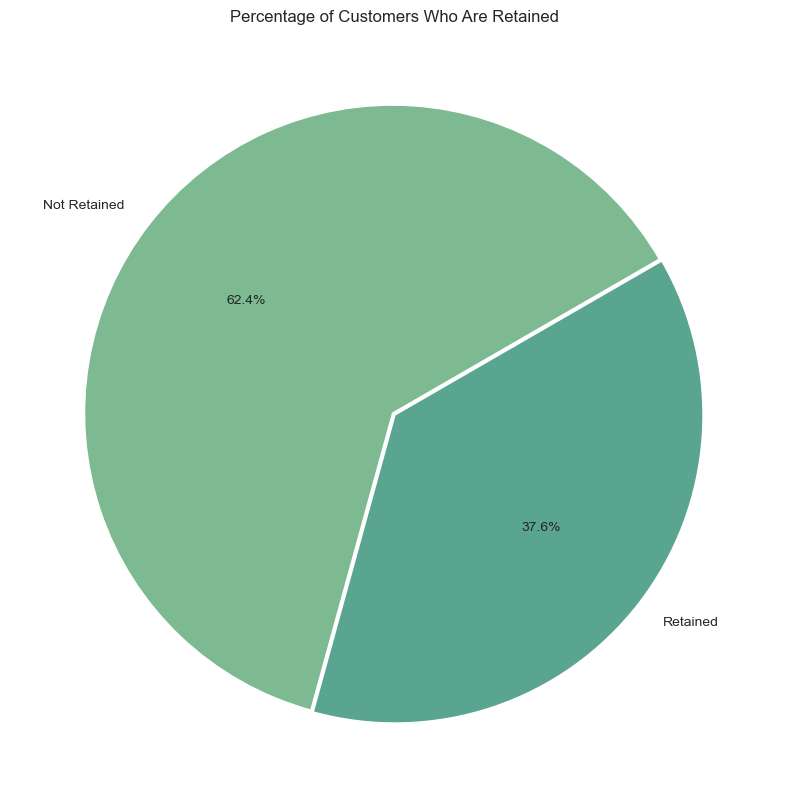

In [13]:
retained_customers = data[data['retained'] == 1].shape[0]

not_retained = data.shape[0] - retained_customers
labels = ['Not Retained', 'Retained']
sizes = [not_retained, retained_customers]
colors = sns.color_palette('crest')[0:5]
explode = (0.01, 0)

plt.figure(figsize = (15,10))
sns.set_style('darkgrid')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=30)
plt.title('Percentage of Customers Who Are Retained')

37.6% of customers who signed up in January of 2014 are still active.

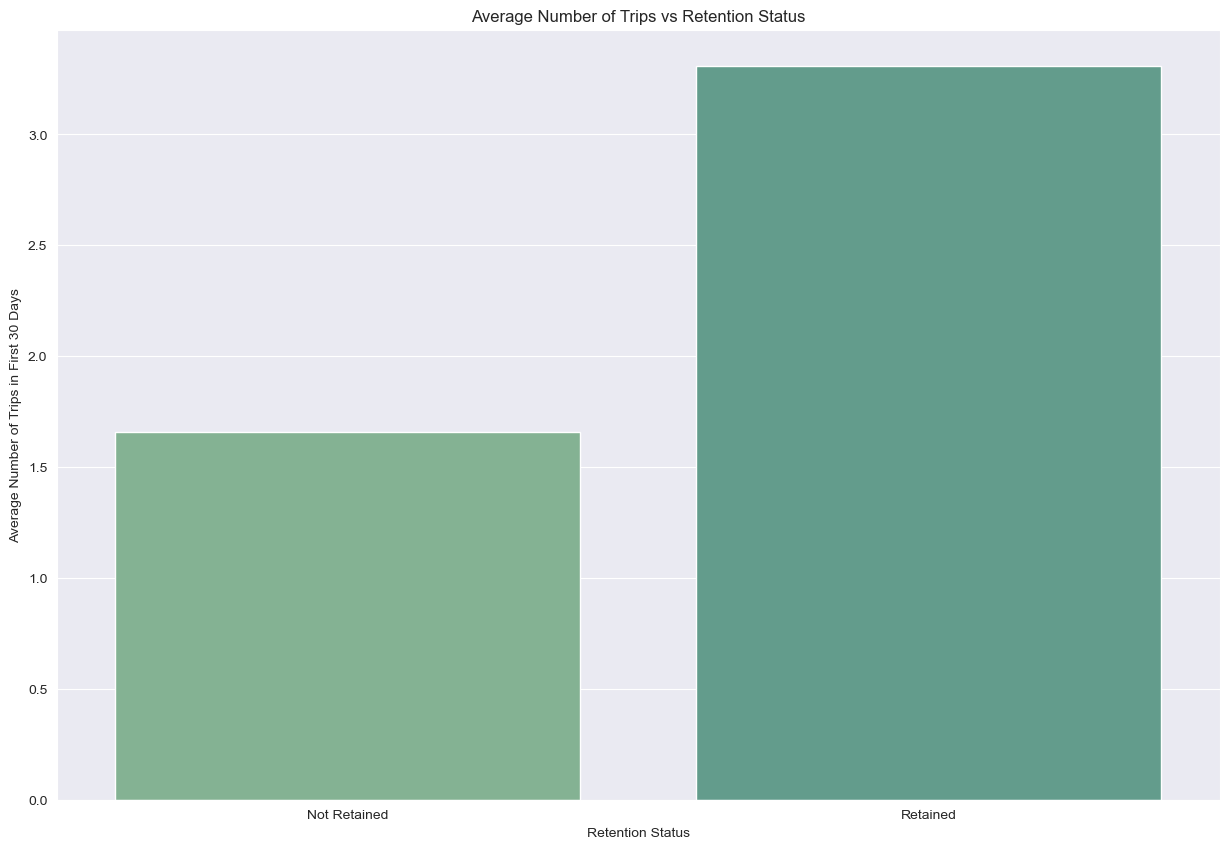

In [14]:
plt.figure(figsize=(15, 10))
sns.set_palette('crest')
sns.barplot(x='retained', y='trips_in_first_30_days', data=data, errorbar=None)
plt.title('Average Number of Trips vs Retention Status')
plt.ylabel('Average Number of Trips in First 30 Days')
plt.xlabel('Retention Status')
plt.xticks([0,1],['Not Retained', 'Retained'])
plt.show()

Customers who are retained took more trips in their first 30 days, on average. 

## Pre Processing The Data:

In [15]:
data = pd.get_dummies(data)

In [16]:
data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,False,True,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,True,False,False,True,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,True,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,False,True,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,False,False,True,True,False


In [17]:
data.dtypes

trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int64
city_Astapor                        bool
city_King's Landing                 bool
city_Winterfell                     bool
phone_Android                       bool
phone_iPhone                        bool
dtype: object

In [18]:
data = data.drop(columns = ['signup_date'])

We know every user present signed up in January of 2014, we don't need to include it in our model. 

In [19]:
data.dtypes

trips_in_first_30_days             int64
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int64
city_Astapor                        bool
city_King's Landing                 bool
city_Winterfell                     bool
phone_Android                       bool
phone_iPhone                        bool
dtype: object

Last trip date still needs to be addressed. 

In [21]:
data['last_trip_date_year'] = data['last_trip_date'].dt.year
data['last_trip_date_month'] = data['last_trip_date'].dt.month
data['last_trip_date_day'] = data['last_trip_date'].dt.day

In [27]:
data.groupby('last_trip_date_year').size()

last_trip_date_year
2014    50000
dtype: int64

In [26]:
data.groupby('last_trip_date_month').size()

last_trip_date_month
1    10147
2     4308
3     4568
4     4588
5     7585
6    18256
7      548
dtype: int64

In [28]:
data.groupby('last_trip_date_day').size()

last_trip_date_day
1     2097
2     1304
3      894
4     1064
5     1069
6     1124
7     1268
8     1382
9     1242
10    1065
11    1341
12    1468
13    1277
14    1389
15    1637
16    1593
17    1412
18    1784
19    1935
20    1765
21    1817
22    1912
23    1617
24    1431
25    1944
26    2343
27    2162
28    2530
29    2840
30    2377
31     917
dtype: int64

We know any last trip was also taken in 2014, we can drop the year. 

In [29]:
data = data.drop(columns = 'last_trip_date_year')

In [32]:
data = data.drop(columns = 'last_trip_date')

In [45]:
data = data.drop(columns = 'last_trip_date_month')

#### *Future Brody here, this month column was casuing a ton of problems. When modeling with this feature included, it only used this feature and none of the other 13. It was also predicting at 100% across all metrics, I knew something was wrong so I dropped it for now* 

In [46]:
X = data.drop(columns = 'retained')
y = data.retained

In [47]:
X.shape, y.shape

((50000, 14), (50000,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25, 
                                                    random_state = 10)

In [49]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(37500, 14) (12500, 14)
(37500,) (12500,)


In [50]:
X_train.dtypes

trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
city_Astapor                 bool
city_King's Landing          bool
city_Winterfell              bool
phone_Android                bool
phone_iPhone                 bool
last_trip_date_day          int32
dtype: object

In [51]:
X_test.dtypes

trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
city_Astapor                 bool
city_King's Landing          bool
city_Winterfell              bool
phone_Android                bool
phone_iPhone                 bool
last_trip_date_day          int32
dtype: object

## Modeling: 

#### I'll be startig with a baseline XGBoost classifier, why?

XGBoost's approach of continuously building new decision trees that improve upon the last has given me the best combination of accuracy and performance in previous work.

Its feature importance attribute also makes it easy to understand which features the model relies on most for making decisions, giving us insight into which features most impact a customer's retention status.

In [52]:
XGB = XGBClassifier(random_state = 42)

In [53]:
XGBModel = XGB.fit(X_train, y_train)
y_pred = XGBModel.predict(X_test)

In [54]:
cnf_matrix_1 = confusion_matrix(y_test, y_pred)
class_report_1 = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(cnf_matrix_1)


print('Classification Report:')
print(class_report_1)

Confusion Matrix:
[[6820  951]
 [1174 3555]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      7771
           1       0.79      0.75      0.77      4729

    accuracy                           0.83     12500
   macro avg       0.82      0.81      0.82     12500
weighted avg       0.83      0.83      0.83     12500



Normalized confusion matrix
[[0.87762193 0.12237807]
 [0.24825545 0.75174455]]


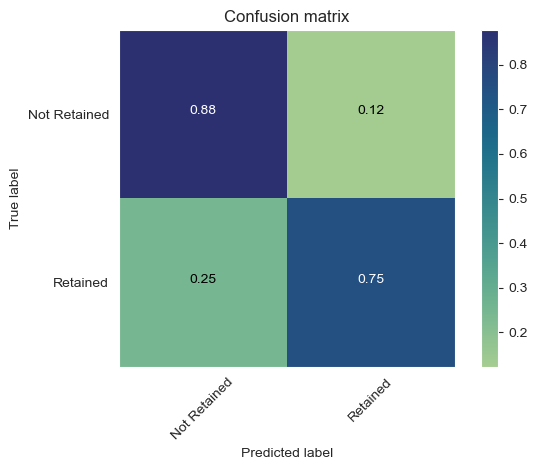

In [61]:
sns.set_style("darkgrid", {'axes.grid' : False})
plot_confusion_matrix(cnf_matrix_1, class_names, normalize = True)

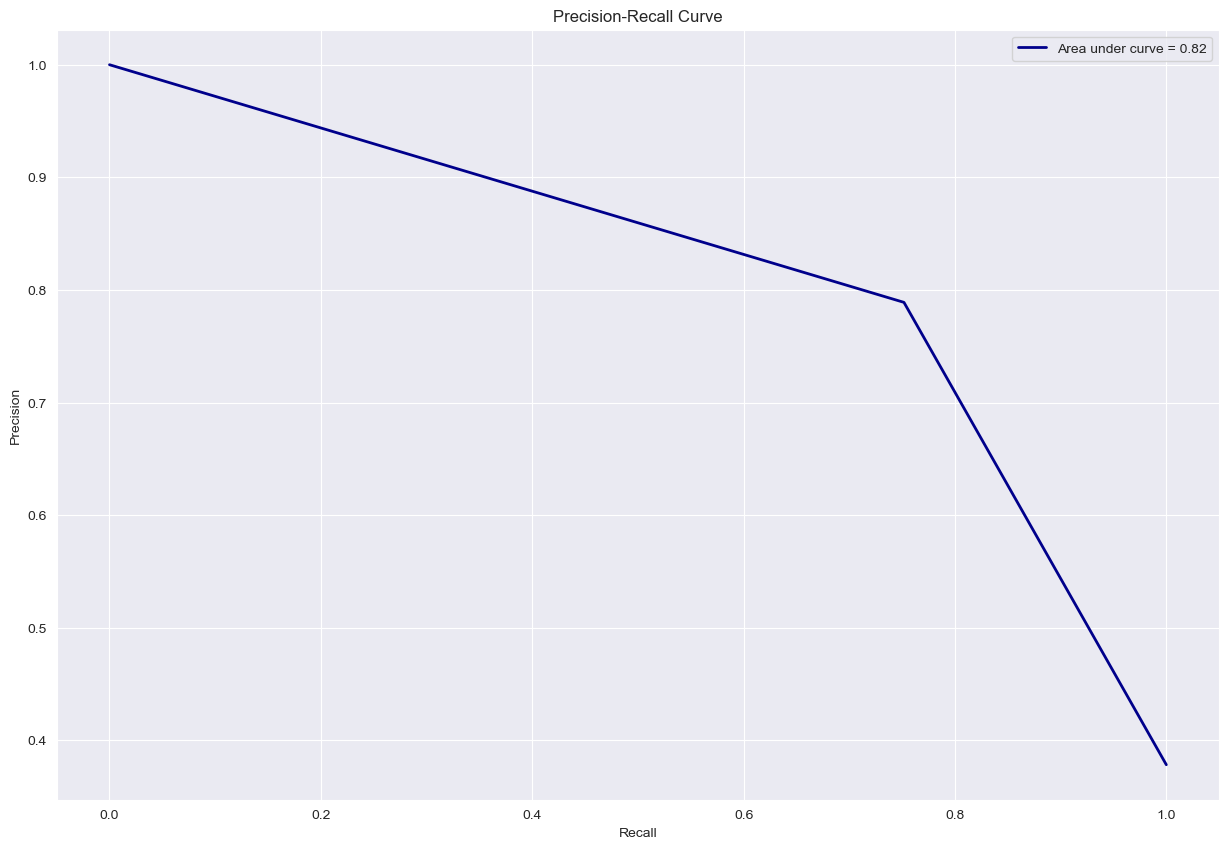

In [83]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
area_under_curve = auc(recall, precision)

plt.figure(figsize=(15, 10))
plt.plot(recall, precision, color='darkblue', lw=2, label=f'Area under curve = {area_under_curve:.2f}')
plt.xlabel('Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [63]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)


cv_results = cross_val_score(XGB, X_train, y_train, cv=kfold, scoring='accuracy')

for i, acc in enumerate(cv_results, start=1):
    print(f'Fold {i}: {acc:.4f}')

mean_accuracy = cv_results.mean()
std_accuracy = cv_results.std()
print(f'\nMean Accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}')

Fold 1: 0.8224
Fold 2: 0.8384
Fold 3: 0.8304
Fold 4: 0.8304
Fold 5: 0.8277

Mean Accuracy: 0.8299 +/- 0.0052


##### For precision vs recall:

Up and to the right = good. The more up and to the right, the better.

Why?

Any movement to the left, which increases our precision (the number of positive predictions that were indeed positive), would reduce our recall (how much of the positive instances of churn our model was able to capture), and vice versa.

#### XGBoost Model Stats:

##### Precision for Class 0 (Customer Not Retained):85%. This means that for all positive class 0 predictions (predicting a customer as not retained), 85% of them were correct.

##### Recall for Class 0 (Customer Not Retained): 88%. This means our model was able to capture 88% of positive instances. 88% of the time, if a customer was indeed not retained, the model captured it.

##### Precision for Class 1 (Customer Retained): 79%. This means that for all positive class 1 predictions (predicting a customer as retained), 79% of them were correct.

##### Recall for Class 1 (Customer Retained): 75%. This means our model was able to capture 75% of positive instances. 75% of the time, if a customer was indeed retained, the model captured it.

Text(0.5, 1.0, 'Feature Importance')

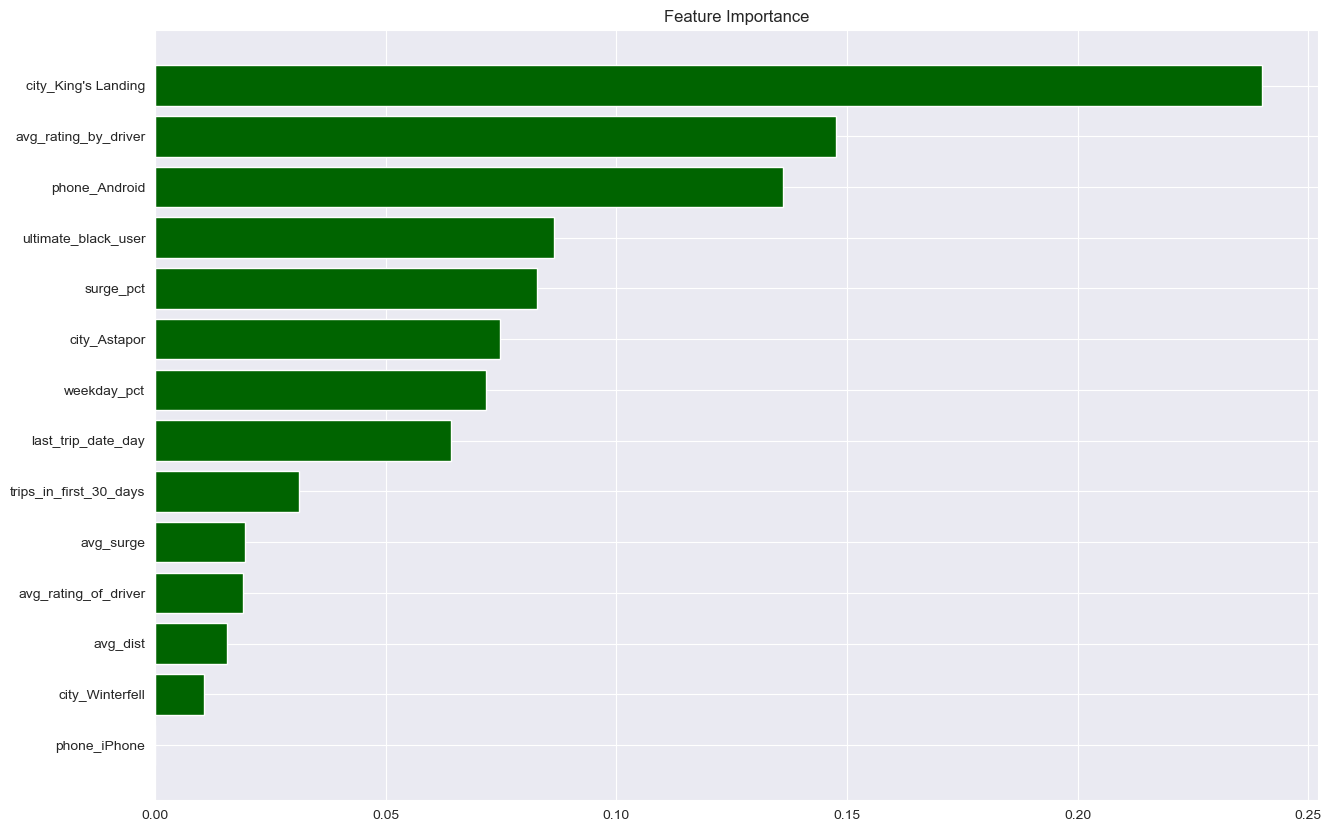

In [64]:
feature_importance = XGBModel.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = 'darkgreen')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

It's important to understand what feature importance is telling us in the context of an XGBoost model.

XGBoost models are like solving a problem with a bunch of friends. You work on the problem one friend at a time, and every friend fixes what the person before them messed up on. Together, after a certain number of tries, you end up with a pretty solid solution.

XGBoost works the same way, but instead of friends, it's decision trees. The first tree makes a guess at what you're trying to predict (in this case, it was predicting a customer as retained or not), then the next tree comes along and builds upon the last until you get to a final tree that's the most accurate prediction.

Then you can ask that final tree what the most important data features were it used to make its predictions, which is defined as the feature that appeared most across all boosting rounds. (Each new tree that's made is a boosting round.)

It does NOT indicate whether or not the influence of these features is positive or negative. It could very well be that the city of Kings Landing is driving a negative impact.

We'll test this by removing it and observing how results change.

In [66]:
X_train1 = X_train.drop(columns = "city_King's Landing")
y_train1 = y_train.drop(columns = "city_King's Landing")

In [67]:
X_test1 = X_test.drop(columns = "city_King's Landing")

In [75]:
XGBModel2 = XGB.fit(X_train1, y_train1)
y_pred2 = XGBModel2.predict(X_test1)

In [76]:
cnf_matrix_2 = confusion_matrix(y_test, y_pred2)
class_report_2 = classification_report(y_test, y_pred2)

print('Confusion Matrix:')
print(cnf_matrix_2)


print('Classification Report:')
print(class_report_2)

Confusion Matrix:
[[6806  965]
 [1176 3553]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      7771
           1       0.79      0.75      0.77      4729

    accuracy                           0.83     12500
   macro avg       0.82      0.81      0.82     12500
weighted avg       0.83      0.83      0.83     12500



Normalized confusion matrix
[[0.87582036 0.12417964]
 [0.24867837 0.75132163]]


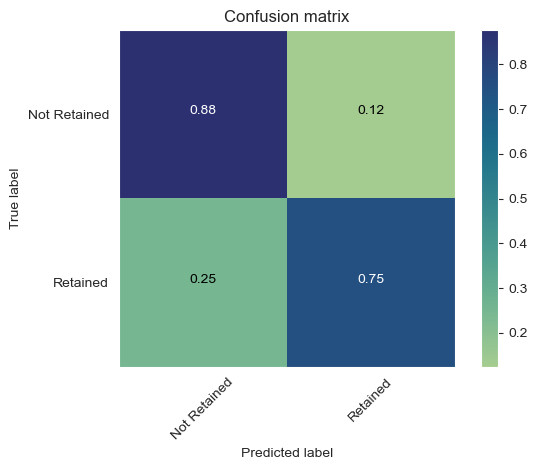

In [77]:
sns.set_style("darkgrid", {'axes.grid' : False})
plot_confusion_matrix(cnf_matrix_2, class_names, normalize = True)

Text(0.5, 1.0, 'Feature Importance')

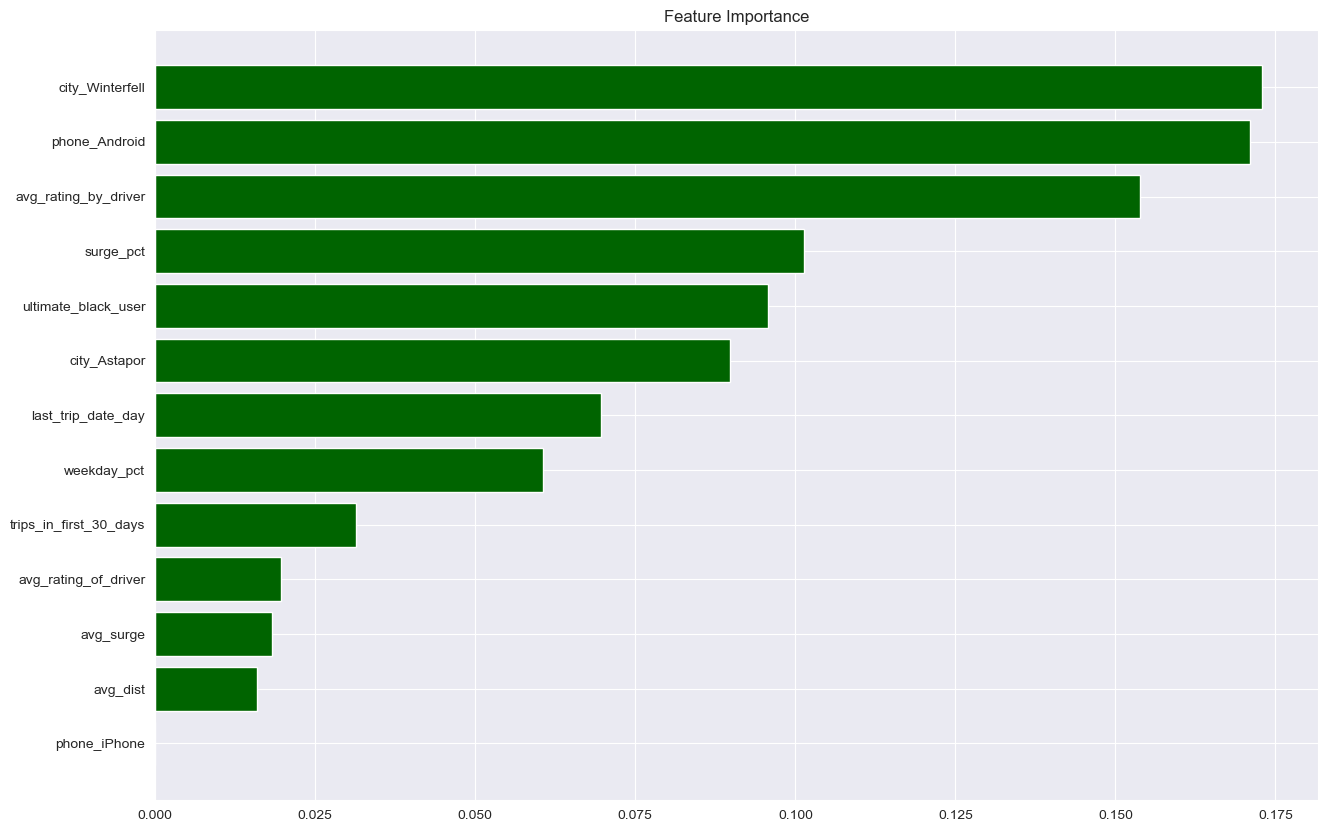

In [79]:
feature_importance1 = XGBModel2.feature_importances_
sorted_idx1 = np.argsort(feature_importance1)
fig = plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
plt.barh(range(len(sorted_idx1)), feature_importance1[sorted_idx1], align='center', color = 'darkgreen')
plt.yticks(range(len(sorted_idx1)), np.array(X_test1.columns)[sorted_idx1])
plt.title('Feature Importance')

Results have hardly changed. It seems like that feature is not as important as the feature importance graph displayed, but that makes sense.

When we encoded the city feature earlier, it split into three columns representing Kings Landing, Winterfell, and Astapor. The column was marked as 'True' if that specific customer was in that city and 'False' if they weren't. If a customer is 'False' for Winterfell and Astapor, then they must be in Kings Landing, so really no data was lost as a result of dropping it.

Looking at the updated feature importance, Winterfell seems to be king now. We'll drop it and observe. 

In [80]:
X_train2 = X_train1.drop(columns = "city_Winterfell")
y_train2 = y_train1.drop(columns = "city_Winterfell")
X_test2 = X_test1.drop(columns = "city_Winterfell")

In [81]:
XGBModel3 = XGB.fit(X_train2, y_train2)
y_pred3 = XGBModel3.predict(X_test2)

In [82]:
cnf_matrix_3 = confusion_matrix(y_test, y_pred3)
class_report_3 = classification_report(y_test, y_pred3)

print('Confusion Matrix:')
print(cnf_matrix_3)


print('Classification Report:')
print(class_report_3)

Confusion Matrix:
[[6779  992]
 [1287 3442]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      7771
           1       0.78      0.73      0.75      4729

    accuracy                           0.82     12500
   macro avg       0.81      0.80      0.80     12500
weighted avg       0.82      0.82      0.82     12500



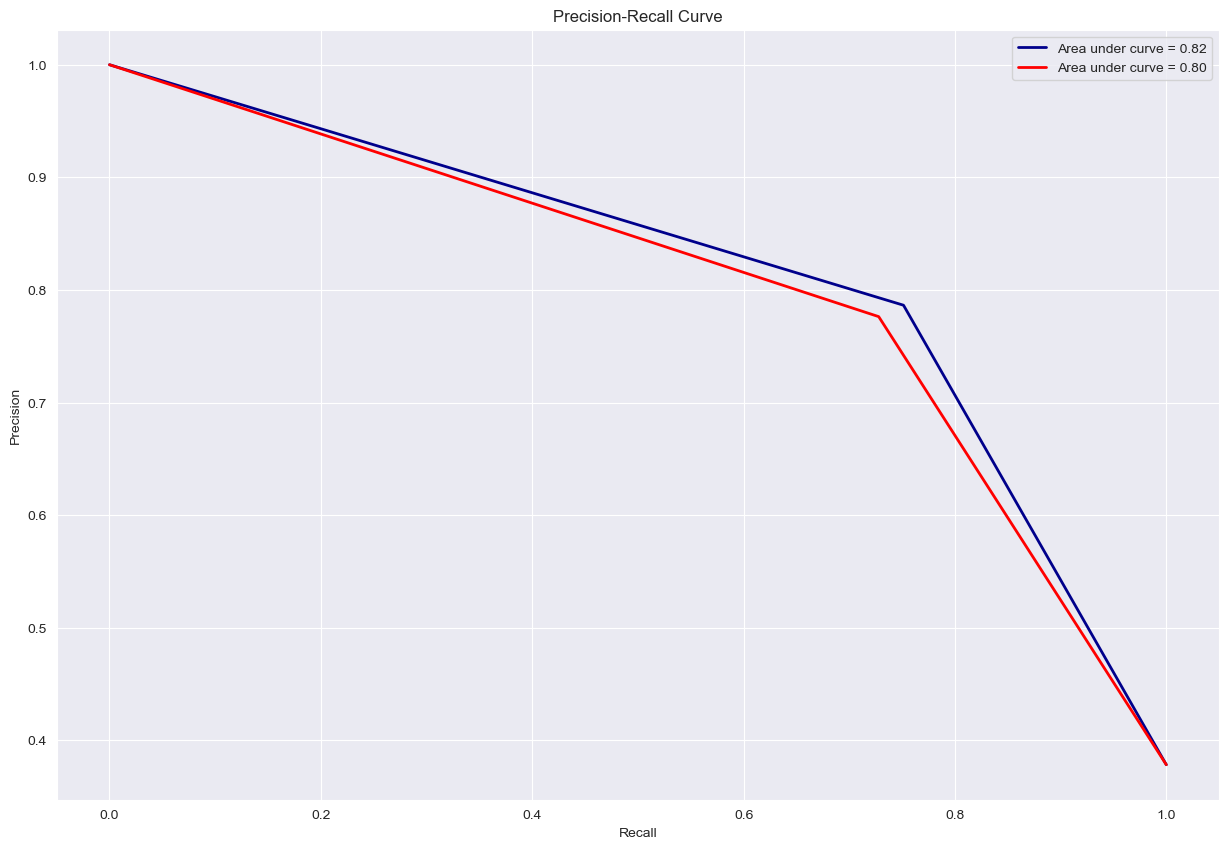

In [89]:
precision1, recall1, _ = precision_recall_curve(y_test.ravel(), y_pred2.ravel())
area_under_curve1 = auc(recall1, precision1)

precision2, recall2, _ = precision_recall_curve(y_test.ravel(), y_pred3.ravel())
area_under_curve2 = auc(recall2, precision2)

plt.figure(figsize=(15, 10))
plt.plot(recall1, precision1, color='darkblue', lw=2, label=f'Area under curve = {area_under_curve1:.2f}')
plt.plot(recall2, precision2, color='red', lw=2, label=f'Area under curve = {area_under_curve2:.2f}')
plt.xlabel('Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Results have dropped across both class 1 precision and recall.

The blue line represents our model prior to dropping the City of Winterfell and the red represents after.

Is this drop due to dropping the feature or just random chance? Let's find out. 

In [90]:
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.proportion import proportion_confint

In [91]:
CM1 = [[6806, 965], [1176, 3553]]
CM2 = [[6779, 992], [1287, 3442]]


a = 6806 
b = 1176
c = 965 
d = 3553

e = 6779
f = 1287
g = 992
h = 3442


result = mcnemar([[a, b], [c, d]], [[e, f], [g, h]])

print(f"McNemar's Test Statistic: {result.statistic}")
print(f"P-value: {result.pvalue}")

if result.pvalue < 0.05:
    print("There is a statistically significant difference.")
else:
    print("There is no statistically significant difference.")

McNemar's Test Statistic: 965.0
P-value: 5.573371367022249e-06
There is a statistically significant difference.


It appears that drop is indeed from removing City of Winterfell, it's an import feature and hold positive predictive power. 

For the purposes of this exercise I will stop here: 

Final Model Stats Once Again (This is the model where we dropped Kings Landing But Kept Everything Else): 

##### Precision for Class 0 (Customer Not Retained):85%. This means that for all positive class 0 predictions (predicting a customer as not retained), 85% of them were correct.

##### Recall for Class 0 (Customer Not Retained): 88%. This means our model was able to capture 88% of positive instances. 88% of the time, if a customer was indeed not retained, the model captured it.

##### Precision for Class 1 (Customer Retained): 79%. This means that for all positive class 1 predictions (predicting a customer as retained), 79% of them were correct.

##### Recall for Class 1 (Customer Retained): 75%. This means our model was able to capture 75% of positive instances. 75% of the time, if a customer was indeed retained, the model captured it.

#### Moving Forward:

The study of this model and its important features can be used to drive confidence in future decisions.

We observed that location is crucial in determining retention status, and residing in Winterfell holds strong predictive power. A deeper study to understand why this is happening is advised.

Having an Android device also shows to be important. Is it driving a positive or a negative change? We could find that out using the same techniques mentioned above. If it's driving a negative change, perhaps the user experience on Android is poor and causing customers to leave the platform.

We could explore each feature and derive insights from them all, which is advised.